In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys as sys
sys.path.append('../py_modules')
import module_clusterheatmap_de as clustermap
import module_plt_params_de
import importlib as imp

df_a = pd.read_table("mitoproteomics_acute_preprocessed.txt")
df_c = pd.read_table("mitoproteomics_chronic_preprocessed.txt")

df_ac = pd.merge(df_a.iloc[:, 0:12], df_c.iloc[:, 0:10], on='gene', how='outer')
df_ac.columns = ['gene', "a_ctrl_1", "a_ctrl_2", "a_ctrl_3", "a_ctrl_4", "a_ctrl_5", "a_eae_1", "a_eae_2", 'a_eae_3', 'a_eae_4', 'a_eae_5', 'a_eae_6', 'c_ctrl_1', 'c_ctrl_2', 'c_ctrl_3', 'c_ctrl_4', 'c_ctrl_5', 'c_eae_1', 'c_eae_2', 'c_eae_3', 'c_eae_4']
df_ac.index = range(len(df_ac))

for i in range(len(df_ac)):
    df_ac.loc[i, 'fc_a'] = np.mean(df_ac.loc[i, df_ac.columns.str.contains("a_eae")]) - np.mean(df_ac.loc[i, df_ac.columns.str.contains("a_ctrl")])
    df_ac.loc[i, 'fc_c'] = np.mean(df_ac.loc[i, df_ac.columns.str.contains("c_eae")]) - np.mean(df_ac.loc[i, df_ac.columns.str.contains("c_ctrl")])

aenrchd_prots = df_a.loc[(df_a.enriched == 1) & (df_a.mitocarta == 1), :].sort_values(by='log2fc')["gene"].tolist()
cenrchd_prots = df_c.loc[(df_c.enriched == 1) & (df_c.mitocarta == 1), :].sort_values(by='log2fc')["gene"].tolist()
enrchd_prots = aenrchd_prots + cenrchd_prots

[None, None, None]

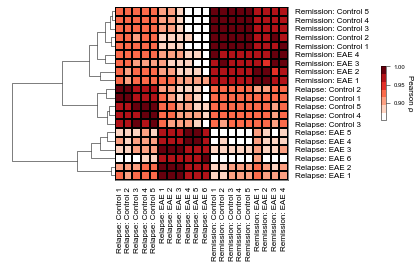

In [2]:
imp.reload(clustermap)
cor = df_ac.iloc[:, 1:21].corr()
col_labels = cor.index.tolist()
row_labels = cor.columns.tolist()
cor = df_ac.iloc[:, 1:21].corr()
col_labels = cor.index.tolist()
col_labels = [('Relapse: ' if x.split('_')[0]=='a' else 'Remission: ') + ('EAE ' if x.split('_')[1]=='eae' else 'Control ') + str(x.split('_')[2]) for x in col_labels]
cor.columns = col_labels
cor.index = col_labels

index = ['A-', 'C-']
name = ['acute', 'chronic']
ct_cmap = dict(zip(index, ['0.3', '0.7']))
celltype = dict(zip(['matching', 'cmap'], [dict(zip(index, name)), ct_cmap]))

index = ['EAE', 'CTRL']
name = ['EAE', 'control']
ct_cmap = dict(zip(index, ['firebrick', 'forestgreen']))
condition = dict(zip(['matching', 'cmap'], [dict(zip(index, name)), ct_cmap]))

clustermap.clustermap(cor, cbar_label="Pearson \u03C1", coldend=None, linewidth=0.25, fancycmap=True, extrapadding=-.1, dendsizefactor=.5, cmethod='complete')
[plt.savefig(f'output/mitoproteomics_acutechronic_correlation.{f}', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=0.05) for f in ['svg', 'pdf', 'png']]

In [3]:
# pca
x = df_ac.loc[:, df_ac.columns.str.contains('ctrl|eae') & ~df_ac.columns.str.contains('mean')]

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = np.transpose(x)
x = x.replace(np.nan, sum(x.min().tolist())/len(x.min().tolist()))
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components = 2)
pcs = pca.fit_transform(x)

pc1var = round(pca.explained_variance_ratio_[0],2) * 100
pc2var = round(pca.explained_variance_ratio_[1],2) * 100

pcadf = pd.DataFrame(data = pcs, columns = ["pc1", "pc2"])
pcadf["sample"] = df_ac.loc[:, df_ac.columns.str.contains('ctrl|eae') & ~df_ac.columns.str.contains('mean')].columns

samples = ['a_eae', 'a_ctrl', 'c_eae', 'c_ctrl']

fig = plt.figure(figsize=(1.1,1.1))
ax = fig.add_axes([0,0,1,1])

for i, sample, color in zip(range(len(samples)), samples, [str(x) for x in np.linspace(0,1,4)]):
    ax.scatter('pc1', 'pc2', data=pcadf.loc[pcadf['sample'].str.contains(sample), :], s=25, edgecolors="black", label=sample, linewidths=0.25, c=color)
#ax.legend(['A-EAE', 'A-CTRL', 'C-EAE', 'C-CTRL'], frameon = False, fontsize=8)
ax.set_xlabel("PC1 ("+str(pc1var)+"%)", fontsize=8)
ax.set_ylabel("PC2 ("+str(pc2var)+"%)", fontsize=8)
ax.set_xticks(np.arange(-60,70)[::30])
ax.set_yticks(np.arange(-60,70)[::30])

ax = fig.add_axes([1.1,0,1,1])
ax.scatter([0,0,0,0], [-3,-1,1,3], c=[str(x) for x in np.linspace(1,0,4)], s=25, lw=.25, edgecolors='k', clip_on=False)
ax.text(0.1, 3, 'EAE (relapse)', va='center')
ax.text(0.1, 1, 'Control (relapse)', va='center')
ax.text(0.1, -1, 'EAE (remission)', va='center')
ax.text(0.1, -3, 'Control (remission)', va='center')
ax.set_ylim([-8,8])
ax.set_xlim([0,2])
ax.axis('off')

[plt.savefig("output/mitoproteomics_acute_chronic_pca.svg", transparent=True, dpi = 900, bbox_inches="tight") for f in ['svg', 'pdf']]
plt.close()

[None, None, None]

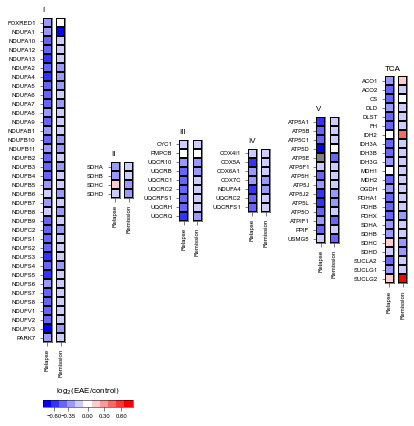

In [3]:
l = pd.read_csv('repos/tca_etc_candidates_figure_210131.csv', sep=';')
l.gene = [x.capitalize() for x in l.gene]

df_a['log2fc_norm'] = [(x-np.mean(df_a.log2fc))/np.sqrt(np.var(df_a.log2fc)) for x in df_a.log2fc]
df_c['log2fc_norm'] = [(x-np.mean(df_c.log2fc))/np.sqrt(np.var(df_c.log2fc)) for x in df_c.log2fc]

l['acute_fc'] = [df_a.loc[df_a.gene == gene, 'log2fc'].values[0] if gene in df_a.gene.tolist() else np.nan for gene in l.gene]
l['chronic_fc'] = [df_c.loc[df_c.gene == gene, 'log2fc'].values[0] if gene in df_c.gene.tolist() else np.nan for gene in l.gene]

l = l.loc[pd.notnull(l.acute_fc) | pd.notnull(l.chronic_fc)]

fig = plt.figure(figsize=(0.25,5))

from matplotlib.colors import LinearSegmentedColormap
custom_map = LinearSegmentedColormap.from_list(N=11, colors=['b', '1' ,'r'], name='custom_map')
custom_map.set_bad(color='grey')

edgecolor = 'k'

for i, group in enumerate(sorted(set(l.group))):
    subset = l.loc[l.group==group,:][::-1]
    subset['gene'] = [x.upper() for x in subset.gene.tolist()]
    subset = subset.sort_values(by='gene', ascending=False)
        
    ax = fig.add_axes([i+i*2.8,5-0.025*len(subset)*0.5,0.5,0.025*len(subset)])
    cmesh = ax.pcolormesh(subset[['acute_fc']], cmap=custom_map, lw=.25, edgecolor=edgecolor, vmin=-.8, vmax=.8)
    ax.set_xticks([0.5])
    ax.set_xticklabels(['Relapse'], rotation=90, ha='center', fontsize=6)
    ax.set_yticks([x+0.5 for x in range(0, len(subset))])
    ax.set_yticklabels(subset.gene)
    ax.set_title(['I', 'II', 'III', 'IV', 'V'][i] if i < 5 else 'TCA', fontsize=8, loc='left')
    
    ax = fig.add_axes([i+i*2.8+0.75,5-0.025*len(subset)*0.5,0.5,0.025*len(subset)])
    cmesh = ax.pcolormesh(subset[['chronic_fc']], cmap=custom_map, lw=.25, edgecolor=edgecolor, vmin=-.8, vmax=.8)
    ax.set_xticks([0.5])
    ax.set_xticklabels(['Remission'], rotation=90, ha='center', fontsize=6)
    ax.set_yticks([])
    ax.set_yticklabels([])
    
cax = fig.add_axes([0,4.37,5,0.02])
cbar = plt.colorbar(cmesh, cax=cax, orientation='horizontal')
cax.set_title('log$_{2}$(EAE/control)', fontsize=8)
cbar.set_ticks([-0.6,-0.35,0,0.3, 0.6])
    
[plt.savefig(f'output/mitoproteomics_acutechronic_heatmap.{f}', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=0.05) for f in ['pdf', 'svg', 'png']]
#plt.close()

[None, None]

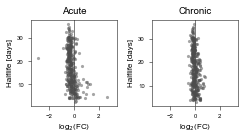

In [5]:
### match abundances to protein half lives (tca cycle, 10.1038/s41467-018-06519-0)

halflives = pd.read_csv('repos/protein_halflives.txt', sep = '\t')
halflives['gene'] = [str(x).split()[0] for x in halflives.gene.tolist()] # take only 1st gene name
halflives = halflives.loc[pd.notna(halflives.halflife_days), :]
halflives_a = pd.merge(df_a.loc[df_a.mitocarta == 1, :], halflives, on = 'gene', how = 'inner') # acute
halflives_c = pd.merge(df_c.loc[df_c.mitocarta == 1, :], halflives, on = 'gene', how = 'inner') # chronic

fig = plt.figure(figsize=(1.2,1.2))

ax = fig.add_axes([0,0,1,1])

ax.scatter(halflives_a.log2fc, halflives_a.halflife_days, s=10, alpha=.5, lw=0, c='0.3')
ax.axvline(0, c='k', zorder=-1)
ax.set_xlabel('log$_{2}$(FC)')
ax.set_ylabel('Halflife [days]')
ax.set_xlim([-3.5,3.5])
ax.set_title('Acute')

ax = fig.add_axes([1.4,0,1,1])
ax.scatter(halflives_c.log2fc, halflives_c.halflife_days, s=10, alpha=.5, lw=0, c='0.3')
ax.axvline(0, c='k', zorder=-1)
ax.set_xlabel('log$_{2}$(FC)')
ax.set_ylabel('Halflife [days]')
ax.set_xlim([-3.5,3.5])
ax.set_title('Chronic')

[plt.savefig(f'output/mitoproteomics_acute_chronic_halflives.{f}', transparent=True, dpi = 900, bbox_inches="tight") for f in ['svg', 'pdf']]